In [3]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
#tipo matlab: pyplot
#objetual: figure, axes
import matplotlib.pyplot as plt
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd

In [2]:

ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


In [34]:
def ecu_spectraldensity(xn,nl,N):
    w_n=0.42-0.5*np.cos((2*np.pi*nl)/(N-1))
    xn=w_n*xn
    s_k=(np.abs(np.fft.fft(xn))**2)/N
    return s_k

In [35]:
def spectraldensity(xn,epoca=119,paciente=0):
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        s_k=ecu_spectraldensity(canal,nl,N)
        sums_k_list.append(s_k)
    return sums_k_list

In [36]:
x=spectraldensity(datos_matriz,119,0)

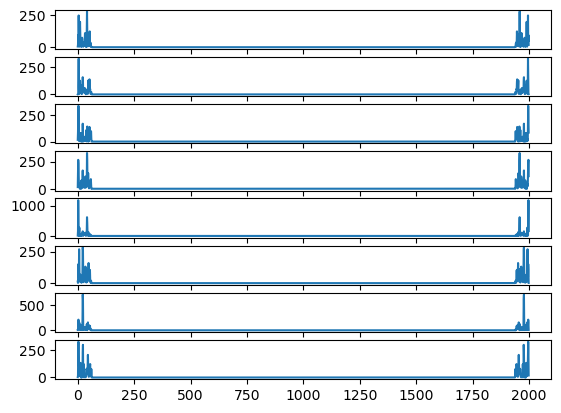

In [37]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()

# 2 
Crear una función que reciba una señal EEG de múltiples épocas, un canal, y devuelva la sumatoria de densidad espectral de potencia, para el rango de frecuencia de 13 a 30 Hz, del promedio de la densidad espectral de potencia de las diferentes épocas de la señal de análisis

In [38]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000):
    data=data[paciente][canal,:,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.arange(N)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(0,fs,num=N)
    return s_k,frecuencia

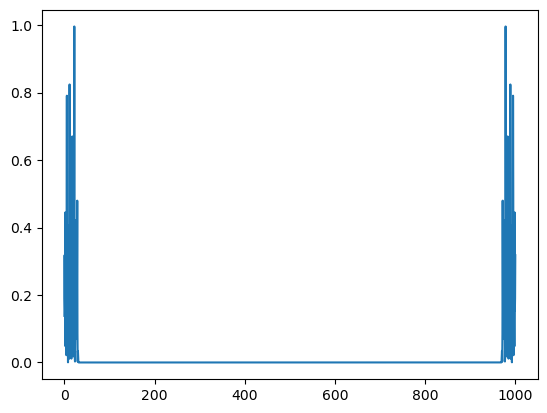

In [39]:
x,f=sum_spectraldensity(datos_matriz,0,0)
plt.plot(f,x)


In [40]:
def spectralrange(x,f,ini=13,end=30):
    bf=np.where((f>=13) &(f<=30))
    f=f[bf]
    x=x[bf]
    return f,x

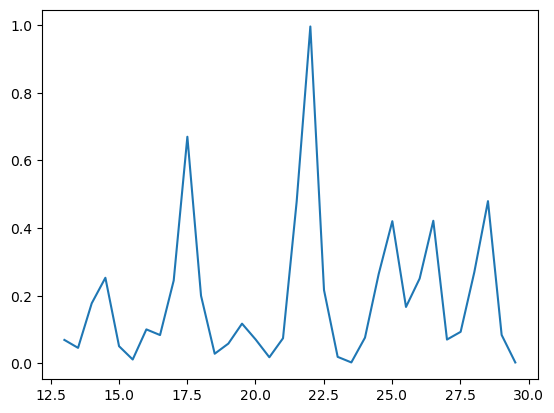

In [41]:
f,x=spectralrange(x,f,13,30)
plt.plot(f,x)

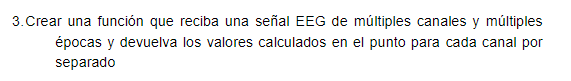

In [42]:
def PSD(xn,paciente=0):
    xn=xn[paciente]
    sums_k_list=[]
    for canal in xn:
        puntos=[]
        for punto in canal:
            p=np.mean(punto)
            puntos.append(p)
        z=np.array(puntos)
        N=len(z)
        nl=np.arange(N)
        s_k=ecu_spectraldensity(z,nl,N)
        sums_k_list.append(s_k)
    return sums_k_list

In [43]:
X=PSD(datos_matriz)

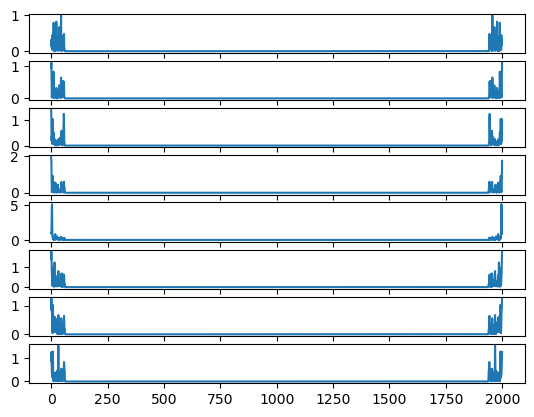

In [44]:
con=1
for i in X:
    plt.subplot(8,1,con)
    plt.plot(i)
    con+=1

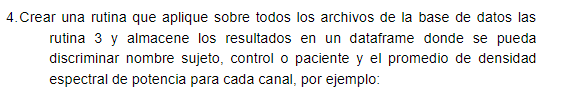

In [45]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
for i in r:
    promcanales=["Control"]
    x=PSD(datos_matriz,i)
    for canal in x:
        promcanales.append(np.mean(canal))
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))
for i in r:
    promcanales=["Parkinson"]
    x=PSD(datos_parkinson,i)
    for canal in x:
        promcanales.append(np.mean(canal))
    datosprompaciente_p.append(promcanales)

In [47]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
for paciente in datosprompaciente: #Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente (lista con primedio de cada canal) y el contador para identificar el paciente
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,0.013220,0.014342,0.016274,0.014887,0.027091,0.021618,0.018548,0.020283
2,Control,0.017571,0.023460,0.025746,0.019884,0.015429,0.115416,0.082684,0.086195
3,Control,0.012148,0.016930,0.021827,0.010207,0.021752,0.010280,0.010021,0.014501
4,Control,0.031334,0.033749,0.041638,0.044321,0.042483,0.125359,0.103761,0.103666
5,Control,0.017223,0.020643,0.018581,0.016663,0.023169,0.037696,0.023996,0.036909
6,Control,0.013239,0.010611,0.010527,0.008004,0.011977,0.024186,0.021741,0.022524
7,Control,0.010213,0.011396,0.014854,0.010857,0.009734,0.022275,0.018560,0.029936
8,Control,0.023973,0.022407,0.016663,0.012449,0.017941,0.086825,0.057059,0.047435
9,Control,0.010339,0.014890,0.018158,0.015056,0.012293,0.060321,0.051205,0.045112
